In [1]:
from tqdm import tqdm
from glob import glob
from matplotlib.colors import ListedColormap
from EmbedSeg.utils.preprocess_data import extract_data, split_train_val, split_train_crops, get_data_properties
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.visualize import visualize_crop_3d, visualize_3d
from EmbedSeg.utils.create_dicts import create_dataset_dict, create_model_dict, create_loss_dict, create_configs, create_test_configs_dict

from EmbedSeg.train import begin_training
from EmbedSeg.test import begin_evaluating
import json, tifffile, numpy as np, os, torch
%matplotlib inline

### Download data

>The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`, using `extract_data` function. 
Next, the `train` directories are split into `train` and `val` using `split_train_val`, but for now we don't transfer any images into the `val` directory (`subset = 0.0`)

In [2]:
data_dir = '../../data'
project_name = 'Mouse-Skull-Nuclei-CBG'

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/Mouse-Skull-Nuclei-CBG.zip',
    data_dir = data_dir,
    project_name = project_name,
)

Downloaded data as ../../data/Mouse-Skull-Nuclei-CBG-sliced.zip
Unzipped data to ../../data/Mouse-Skull-Nuclei-CBG-sliced/download/


In [4]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.0)

Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-sliced/train/images/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-sliced/train/masks/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-sliced/val/images/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-sliced/val/masks/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-sliced/test/images/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-sliced/test/masks/
Train-Val-Test Images/Masks copied to ../../data/Mouse-Skull-Nuclei-CBG-sliced


### Specify desired centre location for spatial embedding of pixels

>Interior pixels of an object instance can either be embedded at the `medoid` or the `centroid`.

In [5]:
center = 'medoid' # 'medoid', 'centroid'

### Calculate some dataset specific properties

>In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. 
We can also specify some properties, for example, set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.

In [5]:
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train'], 
                                          test_name=['test'], mode='3d_sliced')

data_properties_dir['data_type']='16-bit'
data_properties_dir['pixel_size_x_microns']=0.073 # set equal to voxel size (microns) in x dimension
data_properties_dir['pixel_size_y_microns']=0.073 # set equal to voxel size (microns) in y dimension
data_properties_dir['pixel_size_z_microns']=0.20 # set equal to voxel size (microns) in z dimension
data_type, foreground_weight, n_z, n_y, n_x, pixel_size_z_microns, pixel_size_x_microns, min_object_size = data_properties_dir['data_type'], float(data_properties_dir['foreground_weight']), int(data_properties_dir['n_z']), int(data_properties_dir['n_y']), int(data_properties_dir['n_x']), float(data_properties_dir['pixel_size_z_microns']), float(data_properties_dir['pixel_size_x_microns']), int(data_properties_dir['min_object_size'])

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]


Foreground weight of the `Mouse-Skull-Nuclei-CBG` dataset set equal to 3.174


100%|█████████████████████████████████████████████| 2/2 [00:22<00:00, 11.25s/it]


Minimum object size of the `Mouse-Skull-Nuclei-CBG` dataset is equal to 662
Mean object size of the `Mouse-Skull-Nuclei-CBG` dataset is equal to 107009.20666666667
Maximum object size of the `Mouse-Skull-Nuclei-CBG` dataset is equal to 334765
Average object size of the `Mouse-Skull-Nuclei-CBG` dataset along `x` is equal to 70.073
Std. dev object size of the `Mouse-Skull-Nuclei-CBG` dataset along `x` is equal to 30.091
Average object size of the `Mouse-Skull-Nuclei-CBG` dataset along `y` is equal to 115.540
Std. dev object size of the `Mouse-Skull-Nuclei-CBG` dataset along `y` is equal to 48.412
Average object size of the `Mouse-Skull-Nuclei-CBG` dataset along `z` is equal to 43.407
Std. dev object size of the `Mouse-Skull-Nuclei-CBG` dataset along `z` is equal to 20.293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.08it/s]


Tile size of the `Mouse-Skull-Nuclei-CBG` dataset set equal to  (n_z = 128, n_y = 512, n_x = 512)


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]

Average background intensity of the `Mouse-Skull-Nuclei-CBG` dataset set equal to 124.718


### Specify cropping configuration parameters

>Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook).  
Note that we automatically calculate  the `crop_size` by using the `avg_object_size` and `std_object_size` through the relation:  
$\text{crop_size_i} = \text{avg_obj_size_i} + \text{n_sigma} \times \text{std_obj_size_i}$ where $i \in \{x,y\}$.  

In [6]:
n_sigma = 1

In [7]:
def round_up_8(x):
    return (x.astype(int)+7) & (-8)

In [8]:
crops_dir = './crops'
crop_size_z = round_up_8(data_properties_dir['avg_object_size_z'] + n_sigma*data_properties_dir['stdev_object_size_z'])
crop_size_y = np.maximum(round_up_8(data_properties_dir['avg_object_size_y'] + n_sigma*data_properties_dir['stdev_object_size_y']),
round_up_8(data_properties_dir['avg_object_size_x'] + n_sigma*data_properties_dir['stdev_object_size_x']))
crop_size_x = crop_size_y
print("Crop size in x and y will be set equal to {}. Crop size in z is set equal to {}".format(crop_size_x, crop_size_z))

Crop size in x and y will be set equal to 168. Crop size in z is set equal to 64


In [9]:
anisotropy_factor = data_properties_dir['pixel_size_z_microns']/data_properties_dir['pixel_size_x_microns']
speed_up = 4
print("Data anisotropy factor is {:.3f}".format(anisotropy_factor))

Data anisotropy factor is 2.740


### Generate Crops

>Images are normalized using `min-max-percentile` scheme (by default) and then cropped and saved using the `process_3d` method. Other options for normalization are `absolute` and `mean-std`.  
Here, `data_subset` defines the directory which is processed. 

In [10]:
norm = 'min-max-percentile' # min-max-percentile, absolute, mean-std

In [12]:
data_subsets = ['train'] 
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
    instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
    image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
    instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
    for i in tqdm(np.arange(len(image_names))):
        process_3d(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, 
                crop_size_x = crop_size_x, crop_size_y = crop_size_y, crop_size_z = crop_size_z,
                center = center, anisotropy_factor = anisotropy_factor, speed_up = speed_up, 
                norm=norm, data_type = data_properties_dir['data_type'])
    print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Created new directory : ./crops/Mouse-Skull-Nuclei-CBG/train/images/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG/train/masks/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG/train/center-medoid/


100%|████████████████████████████████████████████| 2/2 [04:35<00:00, 137.62s/it]

Cropping of images, instances and centre_images for data_subset = `train` done!


### Keep some crops for validation

>Since there were only $2$ train image volumes, instead of reserving a subset of image volumes for validation (as is general practice),  we reserve some of the crops generated from the train image volumes for validation.

In [13]:
split_train_crops(project_name = project_name, center = center, crops_dir = crops_dir, subset = 0.15)

Created new directory : ./crops/Mouse-Skull-Nuclei-CBG/val/images/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG/val/masks/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG/val/center-medoid/
Val Images/Masks/Center-medoid-image crops saved at ./crops/Mouse-Skull-Nuclei-CBG/val


### Visualize cropped images, corresponding ground truth masks and object center images 

>Some of these cropped images and their label masks are visualized. The label masks are colored with a glasbey-style color map stored in `new_cmap`.

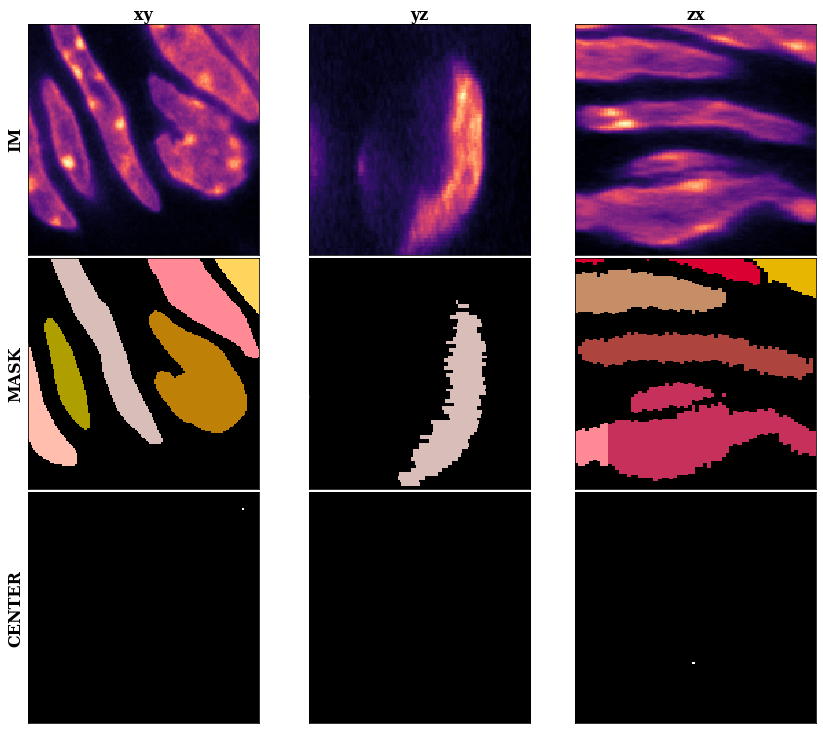

In [11]:
new_cmap = np.load('../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_crop_3d(data_dir=crops_dir, project_name=project_name, train_val_dir='val', center=center, 
                  new_cmp=new_cmap, anisotropy=anisotropy_factor)

### Specify training dataset-related parameters

>We create a `train_dataset_dict` dictionary using the crops extracted from the train images and masks 

In [11]:
train_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                         project_name = project_name,  
                                         center = center, 
                                         size = len(os.listdir(os.path.join(crops_dir, project_name, 'train', 'images'))), 
                                         batch_size = 2, 
                                         type = 'train',
                                         name = '3d')

`train_dataset_dict` dictionary successfully created with: 
 -- train images accessed from ./crops/Mouse-Skull-Nuclei-CBG/train/images, 
 -- number of images per epoch equal to 128, 
 -- batch size set at 2, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify val dataset-related parameters

>We create a `val_dataset_dict` dictionary using the crops extracted from the val images and masks 

In [12]:
val_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                       project_name = project_name, 
                                       center = center, 
                                       size = len(os.listdir(os.path.join(crops_dir, project_name, 'val', 'images'))),  
                                       batch_size = 16, 
                                       type ='val',
                                       name ='3d')

`val_dataset_dict` dictionary successfully created with: 
 -- val images accessed from ./crops/Mouse-Skull-Nuclei-CBG/val/images, 
 -- number of images per epoch equal to 22, 
 -- batch size set at 16, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify model-related parameters

>Set the `input_channels` attribute equal to the number of channels in the input images. 
In the cell after this one, a `model_dataset_dict` and a `loss_dict` dictionary is created.

In [13]:
input_channels = 1
num_classes = [6, 1] 

In [14]:
model_dict = create_model_dict(input_channels = 1,
                              num_classes = [6,1],
                              name = '3d')

`model_dict` dictionary successfully created with: 
 -- num of classes equal to 1, 
 -- input channels equal to [6, 1], 
 -- name equal to branched_erfnet_3d


In [15]:
loss_dict = create_loss_dict(n_sigma = 3, foreground_weight = foreground_weight)

`loss_dict` dictionary successfully created with: 
 -- foreground weight equal to 3.174, 
 -- w_inst equal to 1, 
 -- w_var equal to 10, 
 -- w_seed equal to 1


### Specify the duration of training by setting `n_epochs`

In the cell after this one, a `configs` dictionary is created.  
The model weights are saved by default at `experiment/Mouse-Skull-Nuclei-CBG-demo`

In [16]:
n_epochs = 10

In [17]:
configs = create_configs(n_epochs = n_epochs,
                         resume_path = None, 
                         save_dir = os.path.join('experiment', project_name+'-'+'demo'), 
                         n_z = n_z,
                         n_y = n_y, 
                         n_x = n_x,
                         anisotropy_factor = pixel_size_z_microns/pixel_size_x_microns,
                        )

`configs` dictionary successfully created with: 
 -- n_epochs equal to 10, 
 -- display equal to False, 
 -- save_dir equal to experiment/Mouse-Skull-Nuclei-CBG-demo, 
 -- n_z equal to 128, 
 -- n_y equal to 512, 
 -- n_x equal to 512, 
 -- one_hot equal to False, 


### Begin training!

>We input the dictionaries created above to the `begin_training` function 

In [18]:
%matplotlib Agg
begin_training(train_dataset_dict, val_dataset_dict, model_dict, loss_dict, configs)

3-D `train` dataloader created! Accessing data from ./crops/Mouse-Skull-Nuclei-CBG/train/
Number of images in `train` directory is 128
Number of instances in `train` directory is 128
Number of center images in `train` directory is 128
*************************
3-D `val` dataloader created! Accessing data from ./crops/Mouse-Skull-Nuclei-CBG/val/
Number of images in `val` directory is 22
Number of instances in `val` directory is 22
Number of center images in `val` directory is 22
*************************
Creating Branched Erfnet 3D with [6, 1] outputs
initialize last layer with size:  torch.Size([16, 6, 2, 2, 2])
Created spatial emb loss function with: n_sigma: 3, foreground_weight: 3.173831196077842
*************************
Created logger with keys:  ('train', 'val', 'iou')
Starting epoch 0
learning rate: 0.0005


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


===> train loss: 1.93
===> val loss: 1.58, val iou: 0.26
=> saving checkpoint
Starting epoch 1
learning rate: 0.0004977494364660346


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/it]


===> train loss: 1.30
===> val loss: 1.32, val iou: 0.36
=> saving checkpoint
Starting epoch 2
learning rate: 0.0004954977417064171


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/it]


===> train loss: 1.22
===> val loss: 1.22, val iou: 0.41
=> saving checkpoint
Starting epoch 3
learning rate: 0.0004932449094349202


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/it]


===> train loss: 1.20
===> val loss: 1.18, val iou: 0.44
=> saving checkpoint
Starting epoch 4
learning rate: 0.0004909909332982877


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


===> train loss: 1.15
===> val loss: 1.16, val iou: 0.45
=> saving checkpoint
Starting epoch 5
learning rate: 0.0004887358068751748


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]


===> train loss: 1.13
===> val loss: 1.13, val iou: 0.47
=> saving checkpoint
Starting epoch 6
learning rate: 0.0004864795236750653


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/it]


===> train loss: 1.10
===> val loss: 1.13, val iou: 0.47
=> saving checkpoint
Starting epoch 7
learning rate: 0.00048422207713716544


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]


===> train loss: 1.06
===> val loss: 1.12, val iou: 0.48
=> saving checkpoint
Starting epoch 8
learning rate: 0.00048196346062927547


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]


===> train loss: 1.04
===> val loss: 1.04, val iou: 0.54
=> saving checkpoint
Starting epoch 9
learning rate: 0.00047970366744663594


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/it]


===> train loss: 1.02
===> val loss: 1.03, val iou: 0.55
=> saving checkpoint


### Your model weights or the pretrained model weights?

> Either use the model trained by you for $10$ epochs or use a pretrained model trained for $200$ epochs (uncomment commented lines)

In [12]:
checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')
# # use the following for the pretrained model weights
# torch.hub.download_url_to_file(url = 'https://owncloud.mpi-cbg.de/index.php/s/52JRPsjtyOqLCgg/download', 
#                                dst = 'pretrained_model', progress=True)
# import zipfile
# with zipfile.ZipFile('pretrained_model', 'r') as zip_ref:
#     zip_ref.extractall('')
# checkpoint_path = os.path.join(project_name+'-'+'demo', 'best_iou_model.pth')
# if os.path.isfile(os.path.join(project_name+'-'+'demo','data_properties.json')): 
#     with open(os.path.join(project_name+'-'+'demo', 'data_properties.json')) as json_file:
#         data = json.load(json_file)
#         data_type = data['data_type']
#         min_object_size = int(data['min_object_size']) 
#         n_z, n_y, n_x = int(data['n_z']), int(data['n_y']), int(data['n_x'])
#         pixel_size_z_microns, pixel_size_y_microns, pixel_size_x_microns = float(data['pixel_size_z_microns']), float(data['pixel_size_y_microns']), float(data['pixel_size_x_microns']) 
        
# if os.path.isfile(os.path.join(project_name+'-'+'demo','normalization.json')): 
#     with open(os.path.join(project_name+'-'+'demo', 'normalization.json')) as json_file:
#         data = json.load(json_file)
#         norm = data['norm']

### Set `tta=True` for better inference

> Setting `tta=True` leads to improved performance, but the trained model takes *longer* to predict per image.  
In the cell after this one, a `test_configs` dictionary is created.

In [13]:
tta = True
save_dir = './inference/' + project_name

In [14]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        min_object_size = min_object_size, 
                                        save_dir = save_dir,
                                        norm = norm, 
                                        data_type = data_type,
                                        n_z = n_z,
                                        n_y = n_y,
                                        n_x = n_x,
                                        anisotropy_factor = pixel_size_z_microns/pixel_size_x_microns,
                                        name = '3d',
                                        seed_thresh = 0.7
                                        )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../../data/Mouse-Skull-Nuclei-CBG, 
 -- trained weights accessed from experiment/Mouse-Skull-Nuclei-CBG-demo/best_iou_model.pth, 
 -- output directory chosen as ./inference/Mouse-Skull-Nuclei-CBG


### Evaluate on unseen test data

>The `test_configs` dictionary created above, is input to the `begin_evaluating` function.

In [15]:
begin_evaluating(test_configs)

3-D `test` dataloader created! Accessing data from ../../../data/Mouse-Skull-Nuclei-CBG/test/
Number of images in `test` directory is 1
Number of instances in `test` directory is 1
Number of center images in `test` directory is 0
*************************
Creating Branched Erfnet 3D with [6, 1] outputs


100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.20s/it]

Mean Average Precision (AP_dsb) at IOU threshold = 0.5 at seediness threshold = 0.70000, is equal to 0.31034


{'fg_thresh': 0.5, 'AP_dsb_05': 0.3103448275862069}

In [16]:
%matplotlib inline
prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir, 'seeds','*.tif')))

### Visualize some results on unseen test data

Image filename is X2_right.tif and index is 0


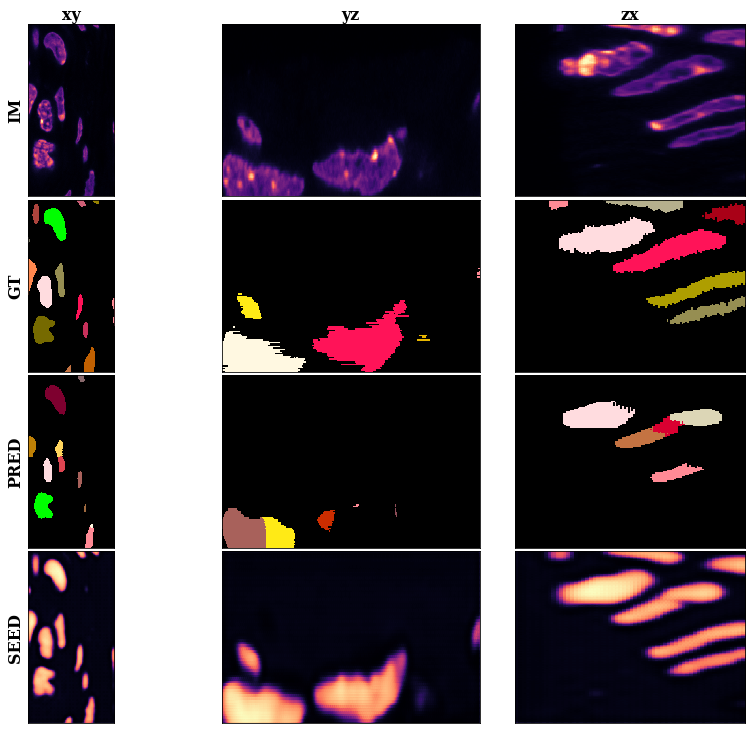

In [17]:
index = 0
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
visualize_3d(image_file_names[index], ground_truth_file_names[index], prediction_file_names[index], seed_file_names[index], new_cmap, anisotropy=pixel_size_z_microns/pixel_size_x_microns)

>If you tried predictions from model trained by you, you could go back and try predictions from the longer trained model as well :)